In [2]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
import string
import nltk
from nltk.corpus import wordnet, cmudict, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('punkt_tab')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger_eng')

from textblob import TextBlob
from gensim.models import LsiModel
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from collections import Counter
import textstat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier

from scipy.sparse import hstack

In [3]:
data = pd.read_csv("../../data/10k_sampled_dataset.csv", encoding="utf-8")
data.head()

,text,source,prompt_id,text_length,word_count
0,"In 1466, perhaps 40,000 people died of the pla...",Flan-T5-XXL,0,336,63
1,Amazon's yet-unnamed Lord of the Rings origina...,GLM-130B,0,2251,393
2,@Holt \n***Hi. I've just rewritten the essay....,Human,0,1994,337
3,Pleasantly surprised! Had a few options for ve...,GLM-130B,0,4182,797
4,Shakespeare’s Othello: A Tragic Hero Research ...,Human,0,12845,2143


# Data Exploration

In [4]:
df = data.copy()
df["source"] = df["source"].apply(lambda x: "AI" if x != "Human" else x)
df.drop(columns="prompt_id", inplace=True)
df.head(3)

,text,source,text_length,word_count
0,"In 1466, perhaps 40,000 people died of the pla...",AI,336,63
1,Amazon's yet-unnamed Lord of the Rings origina...,AI,2251,393
2,@Holt \n***Hi. I've just rewritten the essay....,Human,1994,337


In [5]:
df["source"].value_counts(normalize=True)

source
Human    0.5577
AI       0.4423
Name: proportion, dtype: float64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         10000 non-null  object
 1   source       10000 non-null  object
 2   text_length  10000 non-null  int64 
 3   word_count   10000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 312.6+ KB


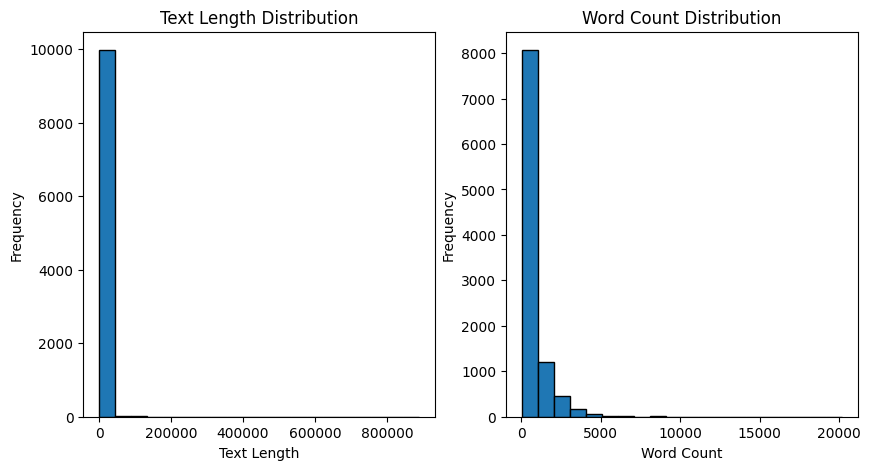

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(df["text_length"], bins=20, edgecolor="black")
axes[0].set_title("Text Length Distribution")
axes[0].set_xlabel("Text Length")
axes[0].set_ylabel("Frequency")

axes[1].hist(df["word_count"], bins=20, edgecolor="black")
axes[1].set_title("Word Count Distribution")
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("Frequency")

plt.show()


In [8]:
# Check if text column contains numbers and special characters

df["contains_numbers"] = df["text"].str.contains(r"\d", regex=True)
df["contains_special_chars"] = df["text"].str.contains(r"[^\w\s]", regex=True)

df.head()

,text,source,text_length,word_count,contains_numbers,contains_special_chars
0,"In 1466, perhaps 40,000 people died of the pla...",AI,336,63,True,True
1,Amazon's yet-unnamed Lord of the Rings origina...,AI,2251,393,True,True
2,@Holt \n***Hi. I've just rewritten the essay....,Human,1994,337,True,True
3,Pleasantly surprised! Had a few options for ve...,AI,4182,797,True,True
4,Shakespeare’s Othello: A Tragic Hero Research ...,Human,12845,2143,True,True


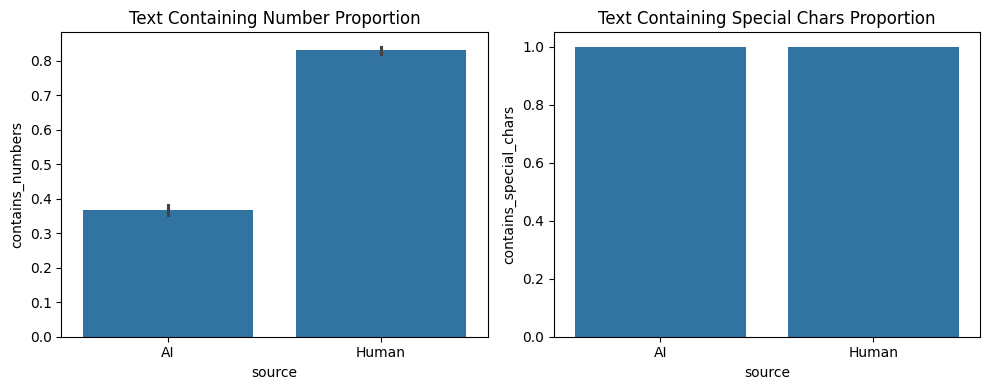

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(x=df["source"], y=df["contains_numbers"], ax=axes[0])
axes[0].set_title("Text Containing Number Proportion")

sns.barplot(x=df["source"], y=df["contains_special_chars"], ax=axes[1])
axes[1].set_title("Text Containing Special Chars Proportion")

plt.tight_layout();

In [10]:
df["contains_numbers"].value_counts()

contains_numbers
True     6262
False    3738
Name: count, dtype: int64

In [11]:
df["contains_special_chars"].value_counts()

contains_special_chars
True     9999
False       1
Name: count, dtype: int64

# Data Cleaning

In [12]:
# Mapping POS tags to WordNet POS tags for better lemmatization

def get_wordnet_pos(text):
    """Convert NLTK POS tag to a format suitable for WordNet Lemmatizer."""
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    tag = nltk.pos_tag([text])[0][1][0].upper() if text else "N" # Default to NOUN
    return tag_dict.get(tag, wordnet.NOUN)  # Default to NOUN if no match

def text_cleaning(text):
    """Clean text but preserve some symbols and numbers."""
    if not isinstance(text, str):  # Handle non-string input
        return ""

    text = text.lower() # Turn to all lowercase
    text = text.strip() # Remove whitespace
    text = re.sub(r'[^\x00-\x7F]+', '', text) # Remove non-ASCII characters

    symbols_to_keep = {"$", "-", "%"} # Keep these symbols
    text_clean = "".join(char if char not in string.punctuation or char in symbols_to_keep else "" for char in text)

    tokenized = word_tokenize(text_clean)
    tagged_words = nltk.pos_tag(tokenized)
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word, _ in tagged_words]
    cleaned_text = " ".join(lemmatized)

    return cleaned_text

In [13]:
# Testing text cleaning function

text_cleaning(df["text"].iloc[4])

'shakespeare othello a tragic hero research paper although his name be associate with athens aristotle be a native of thrace where he be born in 384 bc his father nicomathus who die while aristotle be young be physician at the court of macedon and the son fortune be always tie to those of the macedonian ruler frost 1942 1962 in 3687 when he be about seventeen aristotle come to athens to study with plato of the academy he stayed there for twenty year unfortunately little be know about the personal relationship between the two great thinker of their time the one bring to a close a long productive career the other in his formative year it be suggest that aristotle have broken off with plato and be ready to leave the academy before the latter death in 3487 frost 19421962 a a pupil of plato aristotle and his master stand among the world very great of philosopher frost 1942 1962 in 3487 philip of macedon attack stagira nearly forty his master dead and his ancestral home destroyed aristotle l

In [14]:
df_clean = df.drop(columns=["contains_numbers", "contains_special_chars"])
df_clean.head()

,text,source,text_length,word_count
0,"In 1466, perhaps 40,000 people died of the pla...",AI,336,63
1,Amazon's yet-unnamed Lord of the Rings origina...,AI,2251,393
2,@Holt \n***Hi. I've just rewritten the essay....,Human,1994,337
3,Pleasantly surprised! Had a few options for ve...,AI,4182,797
4,Shakespeare’s Othello: A Tragic Hero Research ...,Human,12845,2143


In [15]:
df_clean["clean_text"] = df_clean["text"].apply(text_cleaning)

# Add new columns to label, calculate char and words in the cleaned_text
df_clean["label"] = df_clean["source"].apply(lambda x: 1 if x == "AI" else 0) #AI=1, Human=0

In [16]:
df_clean = df_clean[["clean_text", "label"]]
df_clean.head(2)

,clean_text,label
0,in 1466 perhaps 40000 people die of the plague...,1
1,amazon yet-unnamed lord of the ring original s...,1


# Feature Extraction - Copying Romaric's features

In [17]:
# Consonnant Density
def cons_density(text):
    if not isinstance(text, str) or not text.strip():  # Handle NaN or empty strings
        return 0.0
    consonant = sum(1 for char in text if char.isalpha() and char not in "aeiouAEIOU")
    vowel = sum(1 for char in text if char.isalpha() and char in "aeiouAEIOU")
    return round((consonant/(vowel + consonant)),3)

In [18]:
# Stress Pattern

#nltk.download("cmudict")
cmu_dict = cmudict.dict()

def get_word_stress(word):
    if word in cmu_dict:
        return sum(int(char) for syllable in cmu_dict[word][0] for char in syllable if char.isdigit())
    return 0

def get_sentence_stress(sentence):
    if not isinstance(sentence, str) or not sentence.strip():
        return 0  # Return 0 for empty input
    words = sentence.split()
    stress_values = [get_word_stress(word) for word in words]
    return sum(stress_values)

In [19]:
# Repetition and Redundancy

def redundance(text):
    # give a redundance score, considering the lenght of each text, if a lemmatized words appears more than three times the mean, it is considered redundant.
    if not isinstance(text, str) or not text.strip():
        return 0  # Handle empty or None inputs safely

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    clean_tokens = [w for w in tokens if w not in stop_words]

    lemmatizer = WordNetLemmatizer()
    final_lemmas = [lemmatizer.lemmatize(lemmatizer.lemmatize(word, 'v'), 'n') for word in clean_tokens]

    word_counts = Counter(final_lemmas)
    if len(word_counts) == 0:
        return 0  # Prevent division by zero if no tokens remain

    mean_freq = sum(word_counts.values()) / len(word_counts)

    score = sum(1 for word, count in word_counts.items() if count > 3 * mean_freq)

    return score

In [20]:
# Emotion and personality with smoothing

def sentiment_polarity(text):
    """Returns the absolute sentiment polarity (0 to 1), with adjustments for better balance."""
    if not isinstance(text, str) or not text.strip():
        return 0.0  # Handle empty or None inputs safely

    sent_pol = TextBlob(text).sentiment.polarity
    abs_pol = abs(round(sent_pol, 3))

    # Smoothing
    if abs_pol < 0.1:  # Treat weak sentiment as neutral
        return 0.0
    if abs_pol > 0.8:  # Cap very strong sentiment to avoid over-amplification
        return 0.8

    return abs_pol

In [21]:
# Unusual word choice

def word_choice(text):
    """Counts occurrences of AI-associated words in the text."""
    if not isinstance(text, str) or not text.strip():
        return 0  # Handle empty or None inputs safely

    common_ai_words =["commendable",'transhumanist', 'meticulous', 'elevate','hello', 'tapestry' 'leverage',
                  'journey', 'headache','resonate','testament','explore', 'binary','delve',
                  'enrich', 'seamless','multifaceted', 'sorry','foster', 'convey', 'beacon',
                  'interplay', 'oh', 'navigate','form','adhere','cannot', 'landscape','remember',
                  'paramount', 'comprehensive', 'placeholder','grammar','real','summary','symphony',
                  'furthermore','relationship','ultimately','profound','art','supercharge','evolve',
                  'beyoud','reimagine','vibrant', 'robust','pivotal','certainly','quinoa','orchestrate','align',
                  'diverse','recommend','annals','note','employ','bustling','indeed','digital','enigma', 'outfit',
                  'indelible','refrain','culture','treat','emerge','meticulous','esteemed','weight','whimsical','bespoke',
                  'highlight','antagonist','unlock','key','breakdown','tailor','misinformation','treasure','paradigm','captivate',
                  'song','underscore','calculate','especially','climate','hedging','inclusive','exercise','ai','embrace',
                  'level','nuance','career','dynamic','accent','ethos','cheap','firstly','online','goodbye'
                  ]
    word_count = 0
    for word in text.split():
        if word in common_ai_words:
            word_count += 1
        else: pass

    return word_count

In [22]:
def coherence(text):
    # uses gensim to measure coherence, use the lsi model(latent semantic indexing, coherence c_v because we provide the text)
    if not isinstance(text, str) or not text.strip():
        return 0.0  # Handle empty or None inputs safely

    tokens = word_tokenize(text)
    if not tokens:
        coherence_score = 0
    else:
        dictionary = corpora.Dictionary([tokens])
        corpus_gensim = [dictionary.doc2bow(tokens)]
        lsa_model = LsiModel(corpus_gensim, id2word=dictionary, num_topics=5)

        coherence_model = CoherenceModel(
            model=lsa_model,
            texts=[tokens],
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
    return coherence_score

In [23]:
# Readability

def reading_ease(text):
    """Returns Flesch Reading Ease score (higher = easier to read)."""
    if not isinstance(text, str) or not text.strip():
        return 0.0  # Handle empty or None input safely
    return textstat.flesch_reading_ease(text)


def gunning_fog(text):
    """Returns Gunning Fog Index (higher = more difficult to read)."""
    if not isinstance(text, str) or not text.strip():
        return 0.0  # Handle empty or None input safely
    return textstat.gunning_fog(text)

In [24]:
df_features = df_clean.copy()
df_features.head(2)

,clean_text,label
0,in 1466 perhaps 40000 people die of the plague...,1
1,amazon yet-unnamed lord of the ring original s...,1


In [25]:
df_features["label"].value_counts(normalize=True)

label
0    0.5577
1    0.4423
Name: proportion, dtype: float64

In [26]:
import swifter
import time

def extract_features(df):

    # Fill missing values (if any)
    df["clean_text"].fillna("", inplace=True)

    return df.assign(
        cons_density = df["clean_text"].swifter.apply(cons_density),
        stress_value = df["clean_text"].swifter.apply(lambda x: get_sentence_stress(x) / len(x) if isinstance(x, str) and x else 0),
        token_redundance = df["clean_text"].swifter.apply(redundance),
        sentiment_score = df["clean_text"].swifter.apply(sentiment_polarity),
        unusual_word_count = df["clean_text"].swifter.apply(word_choice),
        coherence_score = df["clean_text"].swifter.apply(coherence),
        reading_ease = df["clean_text"].apply(textstat.flesch_reading_ease),
        readability_score = df["clean_text"].apply(textstat.gunning_fog)
    )

/Users/till/.pyenv/versions/3.10.6/envs/fake-data-detector/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
df_features = extract_features(df_features)

df_features.head(2)

Pandas Apply:  14%|█▍        | 1445/10000 [1:20:37<3:35:40,  1.51s/it]   Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/till/.pyenv/versions/3.10.6/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
Pandas Apply:  14%|█▍        | 1445/10000 [1:20:38<7:57:23,  3.35s/it]    exitcode = _main(fd, parent_sentinel)
  File "/Users/till/.pyenv/versions/3.10.6/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/till/.pyenv/versions/3.10.6/envs/fake-data-detector/lib/python3.10/site-packages/gensim/__init__.py", line 11, in <module>
    from gensim import parsing, corpora, matutils, interfaces, models, similarities, utils  # noqa:F401
  File "/Users/till/.pyenv/versions/3.10.6/envs/fake-data-detector/lib/python3.10/site-packages/gensim/parsing/__init__.py", line 4, in <module>
    from .preprocessing import (  # noqa:F401
  File "/Users/till/.pyenv/versions/3.10.6/envs/f

KeyboardInterrupt: 

In [ ]:
df_features = df_features.drop(columns=["clean_text", "label"])

df_features.head(2)

,cons_density,stress_value,token_redundance,sentiment_score,unusual_word_count,coherence_score,reading_ease,readability_score
0,0.590,0.154613,2,0.000,2,0.253499,-345.36,162.78
1,0.606,0.164345,2,0.167,0,1.000000,8.55,27.38


# Preprocessing

In [ ]:
# Scale features

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

In [ ]:
# Text vectorization using TF-IDF

X_text = df_clean["clean_text"]

vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')

X_vec = vectorizer.fit_transform(X_text)

In [ ]:
X_vec.shape

(1000, 10000)

In [ ]:
# Join the dateset

X_final = hstack([X_vec, df_scaled])

X_final.shape

(1000, 10008)

# Model Training & Evaluation

In [ ]:
# Exclude warnings from printing out

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
# Train, test, split

y = df_clean["label"]

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Split for validation data

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (720, 10008) (720,)
Validation set shape: (80, 10008) (80,)
Test set shape: (200, 10008) (200,)


In [ ]:
# Evaluate model

def evaluate_model(model_name, y_true, y_pred, y_prob):
    loss = log_loss(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    print(f"{model_name}")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"ROC-AUC: {auc:.4f}")

In [ ]:
# Confusion Matrix

def conf_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human (0)', 'AI (1)'], yticklabels=['Human (0)', 'AI (1)'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} - Confusion Matrix");

### GRADIENT BOOSTING

In [ ]:
epochs = 200

grad_boost = GradientBoostingClassifier(
    max_depth=3,
    n_estimators=epochs,
    learning_rate=0.1)

grad_boost.fit(X_train, y_train)

train_acc_history = []
val_acc_history = []

best_val_acc = 0.0
best_epoch = 0

train_stages = grad_boost.staged_predict(X_train)
val_stages = grad_boost.staged_predict(X_val)

for epoch, (train_pred, val_pred) in enumerate(zip(train_stages, val_stages), start=1):
    # Calculate accuracies
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)

    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    # Track the best validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch

    print(f"Epoch {epoch}/{epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

print(f"\nBest Validation Accuracy: {best_val_acc:.4f} at epoch {best_epoch}")

Epoch 1/200 - Train Acc: 0.5764, Val Acc: 0.5125
Epoch 2/200 - Train Acc: 0.5861, Val Acc: 0.5125
Epoch 3/200 - Train Acc: 0.7139, Val Acc: 0.7375
Epoch 4/200 - Train Acc: 0.8458, Val Acc: 0.8125
Epoch 5/200 - Train Acc: 0.8528, Val Acc: 0.8250
Epoch 6/200 - Train Acc: 0.8528, Val Acc: 0.8250
Epoch 7/200 - Train Acc: 0.8458, Val Acc: 0.8500
Epoch 8/200 - Train Acc: 0.8611, Val Acc: 0.8375
Epoch 9/200 - Train Acc: 0.8639, Val Acc: 0.8500
Epoch 10/200 - Train Acc: 0.8639, Val Acc: 0.8375
Epoch 11/200 - Train Acc: 0.8667, Val Acc: 0.8375
Epoch 12/200 - Train Acc: 0.8722, Val Acc: 0.8375
Epoch 13/200 - Train Acc: 0.8764, Val Acc: 0.8250
Epoch 14/200 - Train Acc: 0.8764, Val Acc: 0.8250
Epoch 15/200 - Train Acc: 0.8847, Val Acc: 0.8375
Epoch 16/200 - Train Acc: 0.8931, Val Acc: 0.8375
Epoch 17/200 - Train Acc: 0.8972, Val Acc: 0.8250
Epoch 18/200 - Train Acc: 0.8986, Val Acc: 0.8250
Epoch 19/200 - Train Acc: 0.9069, Val Acc: 0.8250
Epoch 20/200 - Train Acc: 0.9111, Val Acc: 0.8250
Epoch 21/

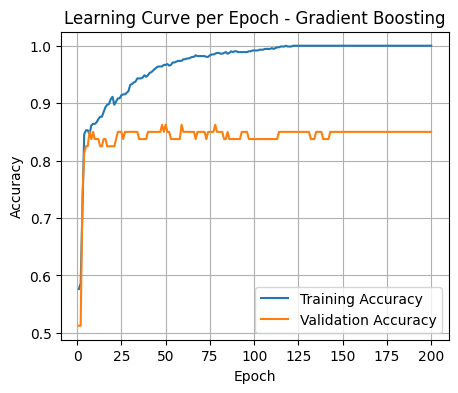

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(range(1, epochs+1), train_acc_history, label="Training Accuracy")
plt.plot(range(1, epochs+1), val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Learning Curve per Epoch - Gradient Boosting")
plt.legend()
plt.grid(True);

In [ ]:
# Gradient Boosting evaluation

grad_y_val_pred = grad_boost.predict(X_val)
grad_y_val_prob = grad_boost.predict_proba(X_val)[:, 1]

grad_loss = log_loss(y_val, grad_y_val_prob)
grad_acc = accuracy_score(y_val, grad_y_val_pred)
grad_prec = precision_score(y_val, grad_y_val_pred)
grad_rec = recall_score(y_val, grad_y_val_pred)
grad_auc = roc_auc_score(y_val, grad_y_val_prob)

print("\nValidation Set Evaluation - Gradient Boosting")
print(f"Loss: {grad_loss:.4f}")
print(f"Accuracy: {grad_acc:.4f}")
print(f"Precision: {grad_prec:.4f}")
print(f"Recall: {grad_rec:.4f}")
print(f"ROC-AUC: {grad_auc:.4f}")


Validation Set Evaluation - Gradient Boosting
Loss: 0.2802
Accuracy: 0.8500
Precision: 0.8462
Recall: 0.8462
ROC-AUC: 0.9543


In [ ]:
# Saving score result to Halim_model_results.ipynb

save_result = [{
    "Model": "Gradient Boost (Halim's cleaning) Full",
    "Loss": f"{grad_loss:.4f}",
    "Accuracy": f"{grad_acc:.4f}"
    }]

df_result = pd.DataFrame(save_result)
csv_file = "10k_model_results.csv"
df_result.to_csv(csv_file, mode="a", index=False, header=not os.path.exists(csv_file))

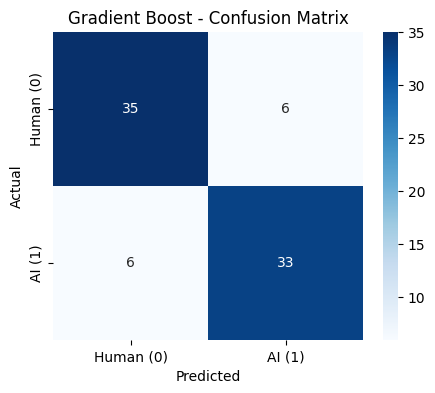

In [ ]:
conf_matrix("Gradient Boost", y_val, grad_y_val_pred)

# Prediction

In [ ]:
def extract_features_single(sentence):
    """
    Extracts features from a single text string (only used for prediction).
    """
    return [
        cons_density(sentence),
        get_sentence_stress(sentence) / len(sentence) if len(sentence) > 0 else 0,  # Avoid division by zero
        redundance(sentence),
        sentiment_polarity(sentence),
        word_choice(sentence),
        coherence(sentence),
        reading_ease(sentence),
        gunning_fog(sentence)]

In [ ]:
def preprocess_input(sentence, vectorizer, scaler):
    """Preprocess the raw input text"""

    # Ensure input is a string
    if not isinstance(sentence, str):
        raise ValueError("Input sentence must be a string")

    cleaned_text = text_cleaning(sentence) # Clean the text
    extracted_features = np.array(extract_features_single(cleaned_text)).reshape(1, -1) # Extract features
    features_scaled = scaler.transform(extracted_features) # Scale features
    text_vectorized = vectorizer.transform([cleaned_text]) # Vectorize clean text
    final_input = hstack([text_vectorized, features_scaled])

    return final_input

In [ ]:
def predict_text(model, sentence, vectorizer, scaler):
    preproc_input = preprocess_input(sentence, vectorizer, scaler)
    prediction_prob = model.predict_proba(preproc_input)[:, 1][0] # Extracts probability of AI clas
    prediction = "AI" if prediction_prob > 0.5 else "Human"
    return prediction, round(prediction_prob, 2)

In [ ]:
df.tail()

,text,source,text_length,word_count,contains_numbers,contains_special_chars
995,Please write a response to ONE of the prompts ...,Human,4259,790,True,True
996,Snap's next-gen Spectacles will be able to lay...,Human,437,68,True,True
997,Visual Place Recognition (VPR) is the ability ...,AI,382,58,False,True
998,Addressing Ex-Felon Disenfranchisement Essay\n...,Human,32647,4997,True,True
999,"The antiques, valued at between PS2,000 and PS...",AI,822,142,True,True


In [ ]:
model = grad_boost
sentence = df["text"][995]

prediction, probability = predict_text(model, sentence, vectorizer, scaler)

print(f"{sentence}")
print(f"Prediction: {prediction} ({probability * 100:.1f}%)")
print(f"Actual: {df['source'][995]}")

Please write a response to ONE of the prompts below in English. The answer should be between 500-700 words. 3) Describe a turning point in your life. Why is it so important to you, and what would your life have become without that that turning point? --------- When my sister turned to face and gave me a last smile before she entered the departure gate, I felt my heart sink. I did not see her at all for the 10 months that she has studied abroad. I only wished for her safety and hoped that she got a great experience. But there was one little voice in my mind that told me that I was afraid. I was afraid that she would not be my same sister who I knew so well, my sister who I had shared all my happiness and grief with. I knew that this was one of the significant moments in her life, but I never thought that it would be a turning point in mine as well. This is the first time my sister went abroad, so we always kept in touch with each other. However, every phone call, her clear happy voice m

/Users/till/.pyenv/versions/3.10.6/envs/fake-data-detector/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
gb_predict = grad_boost.predict(X_test)

print(classification_report(y_test, gb_predict))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       103
           1       0.80      0.89      0.84        97

    accuracy                           0.83       200
   macro avg       0.84      0.84      0.83       200
weighted avg       0.84      0.83      0.83       200

